In [ ]:
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str})
data.shape

(541909, 8)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [ ]:
#Missing values
#How many % of missing values do we have for each feature?

In [ ]:
missing_percentage = data.isnull().sum() / data.shape[0] * 100
missing_percentage

InvoiceNo       0.000000
StockCode       0.000000
Description     0.313597
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.002680
CustomerID     34.522501
Country         0.002680
dtype: float64

In [ ]:
data[data.Description.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockCodeLength,nNumericStockCode
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom,5,5
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom,5,5
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom,5,5
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom,5,5
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom,6,5


In [ ]:
#How often do we miss the customer as well?

In [ ]:
data[data.Description.isnull()].CustomerID.isnull().value_counts()

True    1454
Name: CustomerID, dtype: int64

In [ ]:
#And the unit price?

In [ ]:
data[data.Description.isnull()].UnitPrice.value_counts()

0.0    1454
Name: UnitPrice, dtype: int64

In [ ]:
#Missing Customer IDs

In [ ]:
data[data.CustomerID.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockCodeLength,nNumericStockCode
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom,5,5
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom,5,5
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom,5,5
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom,5,5
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom,5,5


In [ ]:
data.loc[data.CustomerID.isnull(), ["UnitPrice", "Quantity"]].describe()

,UnitPrice,Quantity
count,135080.000000,135080.000000
mean,8.076577,1.995573
std,151.900816,66.696153
min,-11062.060000,-9600.000000
25%,1.630000,1.000000
50%,3.290000,1.000000
75%,5.450000,3.000000
max,17836.460000,5568.000000


In [ ]:
#Hidden missing descriptions
#Can we find "nan"-Strings?

In [ ]:
data.loc[data.Description.isnull()==False, "lowercase_descriptions"] = data.loc[
    data.Description.isnull()==False,"Description"
].apply(lambda l: l.lower())

data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("nan" in l, True, False)
).value_counts()

False    539724
True        731
Name: lowercase_descriptions, dtype: int64

In [ ]:
#Can we find empty ""-strings?

In [ ]:
data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("" == l, True, False)
).value_counts()

False    540455
Name: lowercase_descriptions, dtype: int64

In [ ]:
data.loc[data.lowercase_descriptions.isnull()==False, "lowercase_descriptions"] = data.loc[
    data.lowercase_descriptions.isnull()==False, "lowercase_descriptions"
].apply(lambda l: np.where("nan" in l, None, l))

In [ ]:
data = data.loc[(data.CustomerID.isnull()==False) & (data.lowercase_descriptions.isnull()==False)].copy()

In [ ]:
data.isnull().sum().sum()

0

In [ ]:
#The Time period
#How long is the period in days?

In [ ]:
data["InvoiceDate"] = pd.to_datetime(data.InvoiceDate, cache=True)

data.InvoiceDate.max() - data.InvoiceDate.min()

Timedelta('373 days 04:24:00')

In [ ]:
print("Datafile starts with timepoint {}".format(data.InvoiceDate.min()))
print("Datafile ends with timepoint {}".format(data.InvoiceDate.max()))

Datafile starts with timepoint 2010-12-01 08:26:00
Datafile ends with timepoint 2011-12-09 12:50:00


In [ ]:
#The invoice number
#How many different invoice numbers do we have?

In [ ]:
data.InvoiceNo.nunique()

22186

In [ ]:
data["IsCancelled"]=np.where(data.InvoiceNo.apply(lambda l: l[0]=="C"), True, False)
data.IsCancelled.value_counts() / data.shape[0] * 100

False    97.81007
True      2.18993
Name: IsCancelled, dtype: float64

In [ ]:
data.loc[data.IsCancelled==True].describe()

,Quantity,UnitPrice,StockCodeLength,nNumericStockCode
count,8896.000000,8896.000000,8896.000000,8896.000000
mean,-30.882981,18.862815,4.945931,4.794402
std,1170.746458,444.590459,0.733139,0.992663
min,-80995.000000,0.010000,1.000000,0.000000
25%,-6.000000,1.450000,5.000000,5.000000
50%,-2.000000,2.950000,5.000000,5.000000
75%,-1.000000,4.950000,5.000000,5.000000
max,-1.000000,38970.000000,7.000000,5.000000


In [ ]:
data = data.loc[data.IsCancelled==False].copy()
data = data.drop("IsCancelled", axis=1)

In [ ]:
#Stockcodes
#How many unique stockcodes do we have?

In [ ]:
data.StockCode.nunique()

3663

In [ ]:
#Which codes are most common?

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


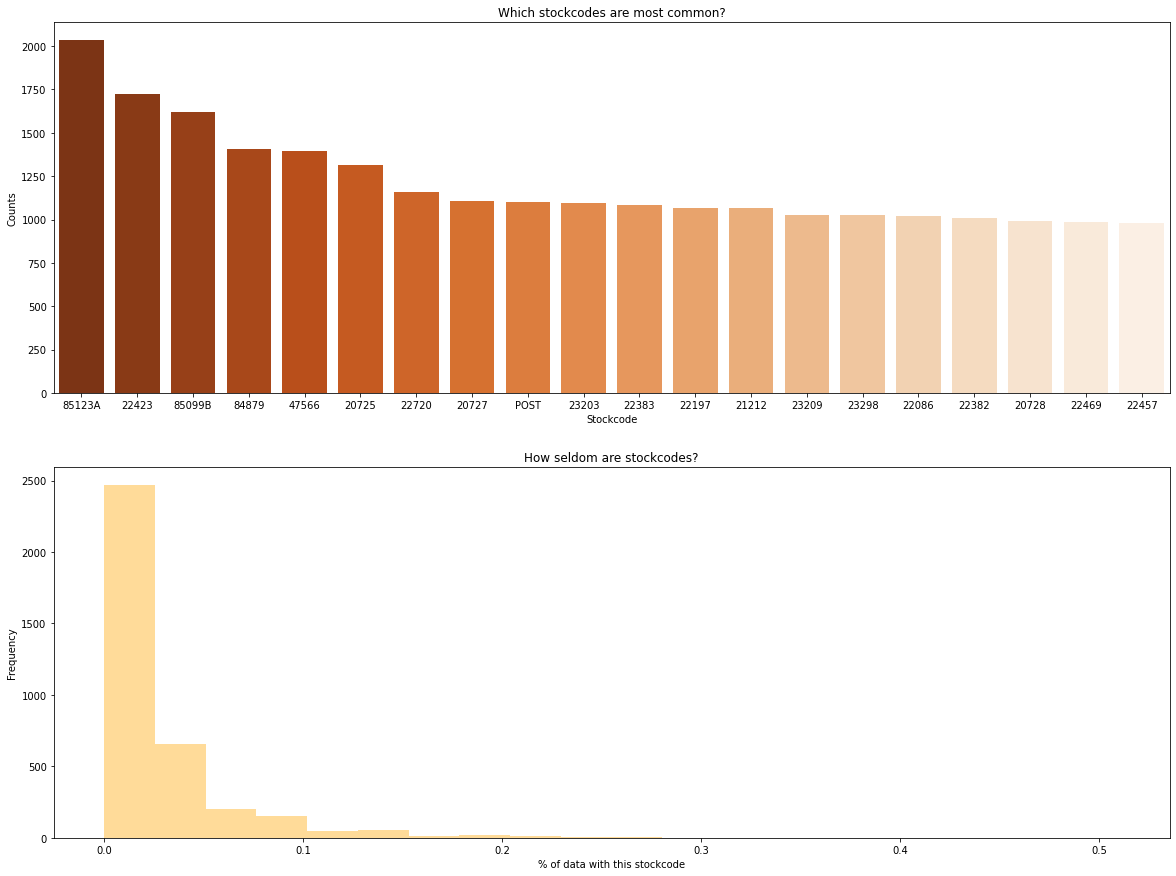

In [ ]:
import seaborn as sns
stockcode_counts = data.StockCode.value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.barplot(stockcode_counts.iloc[0:20].index,
            stockcode_counts.iloc[0:20].values,
            ax = ax[0], palette="Oranges_r")
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Stockcode")
ax[0].set_title("Which stockcodes are most common?");
sns.distplot(np.round(stockcode_counts/data.shape[0]*100,2),
             kde=False,
             bins=20,
             ax=ax[1], color="Orange")
ax[1].set_title("How seldom are stockcodes?")
ax[1].set_xlabel("% of data with this stockcode")
ax[1].set_ylabel("Frequency");

In [ ]:
#count the number of numeric chars in and the length of the stockcode:

In [ ]:
def count_numeric_chars(l):
    return sum(1 for c in l if c.isdigit())

data["StockCodeLength"] = data.StockCode.apply(lambda l: len(l))
data["nNumericStockCode"] = data.StockCode.apply(lambda l: count_numeric_chars(l))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


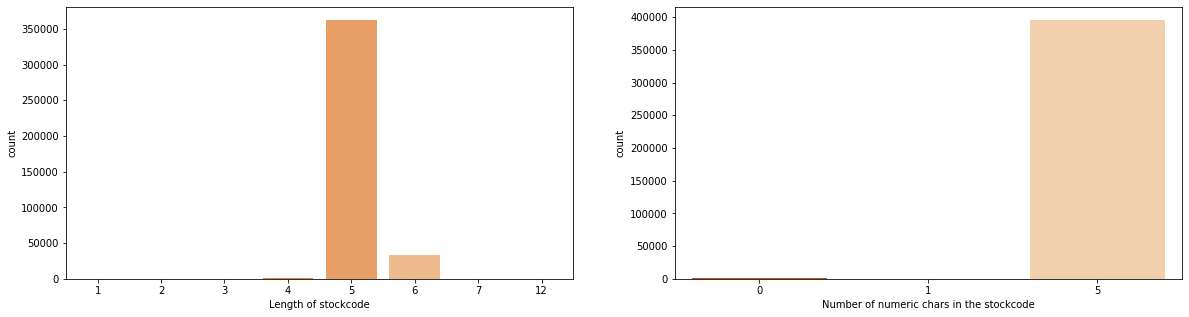

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(data["StockCodeLength"], palette="Oranges_r", ax=ax[0])
sns.countplot(data["nNumericStockCode"], palette="Oranges_r", ax=ax[1])
ax[0].set_xlabel("Length of stockcode")
ax[1].set_xlabel("Number of numeric chars in the stockcode");

In [ ]:
data.loc[data.nNumericStockCode < 5].lowercase_descriptions.value_counts()

postage                       1099
manual                         290
carriage                       133
dotcom postage                  16
bank charges                    12
pads to match all cushions       4
Name: lowercase_descriptions, dtype: int64

In [ ]:
data = data.loc[(data.nNumericStockCode == 5) & (data.StockCodeLength==5)].copy()
data.StockCode.nunique()

2783

In [ ]:
data = data.drop(["nNumericStockCode", "StockCodeLength"], axis=1)

In [ ]:
#Descriptions
#How many unique descriptions do we have?

In [ ]:
data.Description.nunique()

2983

In [ ]:
#And which are most common?

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


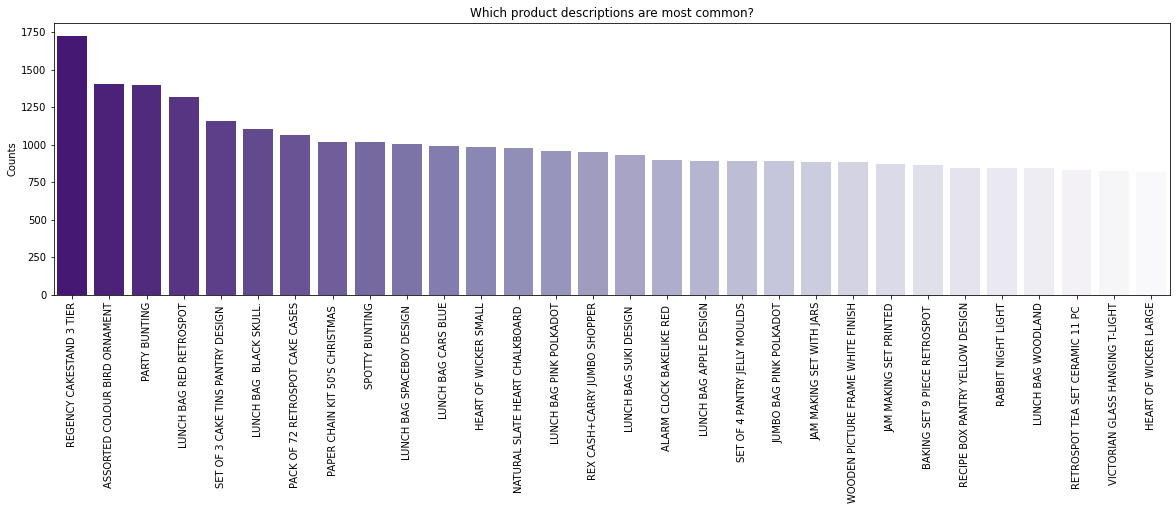

In [ ]:
description_counts = data.Description.value_counts().sort_values(ascending=False).iloc[0:30]
plt.figure(figsize=(20,5))
sns.barplot(description_counts.index, description_counts.values, palette="Purples_r")
plt.ylabel("Counts")
plt.title("Which product descriptions are most common?");
plt.xticks(rotation=90);

In [ ]:
def count_lower_chars(l):
    return sum(1 for c in l if c.islower())

In [ ]:
data["DescriptionLength"] = data.Description.apply(lambda l: len(l))
data["LowCharsInDescription"] = data.Description.apply(lambda l: count_lower_chars(l))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


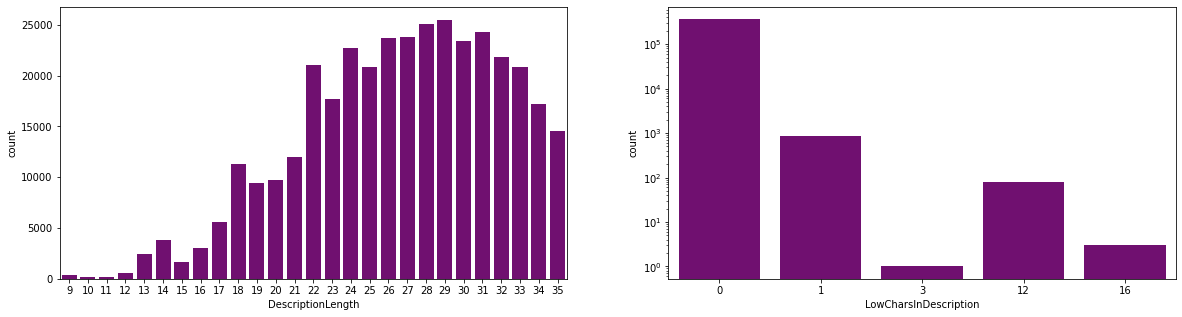

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(data.DescriptionLength, ax=ax[0], color="Purple")
sns.countplot(data.LowCharsInDescription, ax=ax[1], color="Purple")
ax[1].set_yscale("log")

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


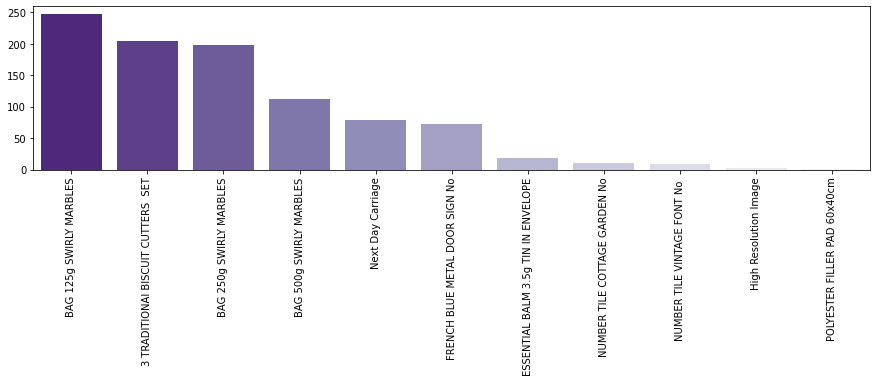

In [ ]:
lowchar_counts = data.loc[data.LowCharsInDescription > 0].Description.value_counts()

plt.figure(figsize=(15,3))
sns.barplot(lowchar_counts.index, lowchar_counts.values, palette="Purples_r")
plt.xticks(rotation=90);

In [ ]:
#Let's compute the fraction of lower with respect to uppercase letters:

In [ ]:
def count_upper_chars(l):
    return sum(1 for c in l if c.isupper())

data["UpCharsInDescription"] = data.Description.apply(lambda l: count_upper_chars(l))

In [ ]:
data.UpCharsInDescription.describe()

count    362522.000000
mean         22.572291
std           4.354845
min           3.000000
25%          20.000000
50%          23.000000
75%          26.000000
max          32.000000
Name: UpCharsInDescription, dtype: float64

In [ ]:
data.loc[data.UpCharsInDescription <=5].Description.value_counts()

Next Day Carriage        79
High Resolution Image     3
Name: Description, dtype: int64

In [ ]:
data = data.loc[data.UpCharsInDescription > 5].copy()

In [ ]:
#And what about the descriptions with a length below 14?

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


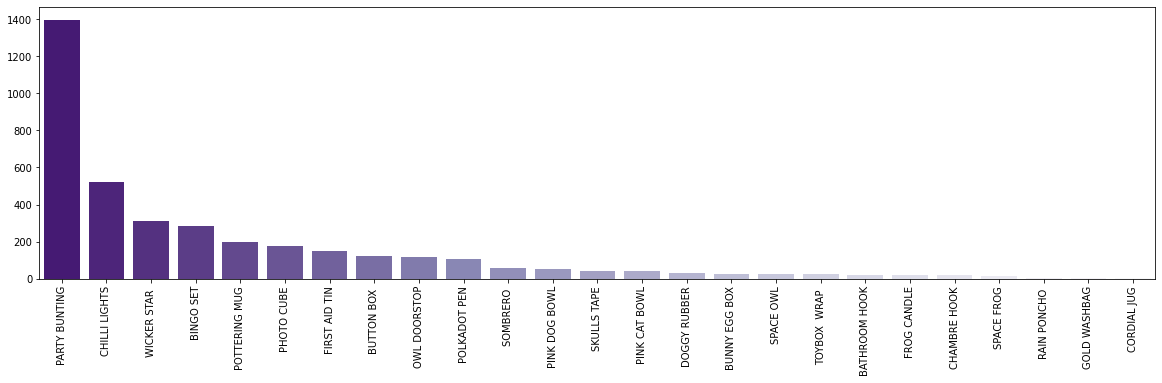

In [ ]:
dlength_counts = data.loc[data.DescriptionLength < 14].Description.value_counts()

plt.figure(figsize=(20,5))
sns.barplot(dlength_counts.index, dlength_counts.values, palette="Purples_r")
plt.xticks(rotation=90);

In [ ]:
data.StockCode.nunique()

2781

In [ ]:
data.Description.nunique()

2981

In [ ]:
data.groupby("StockCode").Description.nunique().sort_values(ascending=False).iloc[0:10]

StockCode
23196    4
23236    4
23244    3
23231    3
23131    3
22937    3
23126    3
23370    3
23366    3
23413    3
Name: Description, dtype: int64

In [ ]:
# we still have stockcodes with multiple descriptions

In [ ]:
data.loc[data.StockCode == "23244"].Description.value_counts()

ROUND STORAGE TIN VINTAGE LEAF    96
STORAGE TIN VINTAGE LEAF           7
CANNISTER VINTAGE LEAF DESIGN      2
Name: Description, dtype: int64

In [ ]:
#Unit Price 

In [ ]:
data.UnitPrice.describe()

count    362440.000000
mean          2.885355
std           4.361812
min           0.000000
25%           1.250000
50%           1.790000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

In [ ]:
data.loc[data.UnitPrice == 0].sort_values(by="Quantity", ascending=False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,lowercase_descriptions,DescriptionLength,LowCharsInDescription,UpCharsInDescription
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256,United Kingdom,asstd design 3d paper stickers,30,0,25
298054,562973,23157,SET OF 6 NATIVITY MAGNETS,240,2011-08-11 11:42:00,0.0,14911,EIRE,set of 6 nativity magnets,26,0,20
436428,574138,23234,BISCUIT TIN VINTAGE CHRISTMAS,216,2011-11-03 11:26:00,0.0,12415,Australia,biscuit tin vintage christmas,29,0,26
314746,564651,23268,SET OF 2 CERAMIC CHRISTMAS REINDEER,192,2011-08-26 14:19:00,0.0,14646,Netherlands,set of 2 ceramic christmas reindeer,35,0,29
314748,564651,21786,POLKADOT RAIN HAT,144,2011-08-26 14:19:00,0.0,14646,Netherlands,polkadot rain hat,18,0,15


In [ ]:
data = data.loc[data.UnitPrice > 0].copy()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


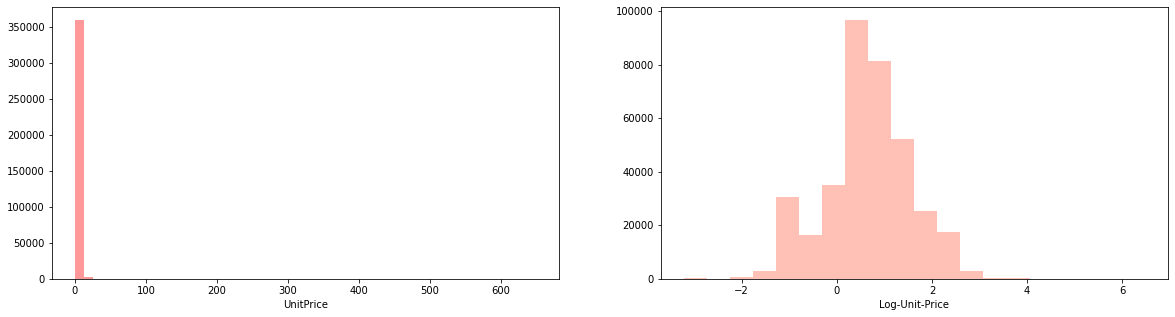

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(data.UnitPrice, ax=ax[0], kde=False, color="red")
sns.distplot(np.log(data.UnitPrice), ax=ax[1], bins=20, color="tomato", kde=False)
ax[1].set_xlabel("Log-Unit-Price");

In [ ]:
np.exp(-2)

0.1353352832366127

In [ ]:
np.exp(3)

20.085536923187668

In [ ]:
np.quantile(data.UnitPrice, 0.95)

8.5

In [ ]:
data = data.loc[(data.UnitPrice > 0.1) & (data.UnitPrice < 20)].copy()

In [ ]:
#Quantities
#The most important one - the target. Let's take a look at its distribution:

In [ ]:
data.Quantity.describe()

count    361608.000000
mean         13.024112
std         187.566510
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


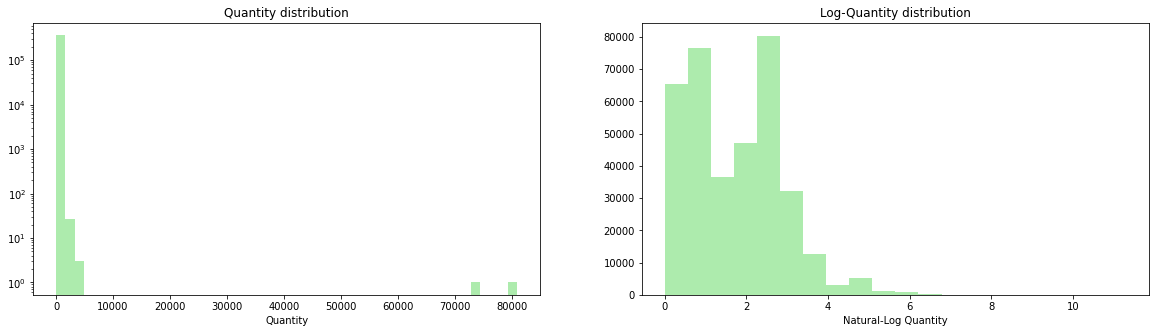

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(data.Quantity, ax=ax[0], kde=False, color="limegreen");
sns.distplot(np.log(data.Quantity), ax=ax[1], bins=20, kde=False, color="limegreen");
ax[0].set_title("Quantity distribution")
ax[0].set_yscale("log")
ax[1].set_title("Log-Quantity distribution")
ax[1].set_xlabel("Natural-Log Quantity");

In [ ]:
np.exp(4)

54.598150033144236

In [ ]:
np.quantile(data.Quantity, 0.95)

36.0

In [ ]:
data = data.loc[data.Quantity < 55].copy()

In [ ]:
#Focus on daily product sales 

In [ ]:
data["Revenue"] = data.Quantity * data.UnitPrice

data["Year"] = data.InvoiceDate.dt.year
data["Quarter"] = data.InvoiceDate.dt.quarter
data["Month"] = data.InvoiceDate.dt.month
data["Week"] = data.InvoiceDate.dt.week
data["Weekday"] = data.InvoiceDate.dt.weekday
data["Day"] = data.InvoiceDate.dt.day
data["Dayofyear"] = data.InvoiceDate.dt.dayofyear
data["Date"] = pd.to_datetime(data[['Year', 'Month', 'Day']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [ ]:
grouped_features = ["Date", "Year", "Quarter","Month", "Week", "Weekday", "Dayofyear", "Day",
                    "StockCode"]

In [ ]:
daily_data = pd.DataFrame(data.groupby(grouped_features).Quantity.sum(),
                          columns=["Quantity"])
daily_data["Revenue"] = data.groupby(grouped_features).Revenue.sum()
daily_data = daily_data.reset_index()
daily_data.head(5)

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,Revenue
0,2010-12-01,2010,4,12,48,2,335,1,10002,60,51.00
1,2010-12-01,2010,4,12,48,2,335,1,10125,2,1.70
2,2010-12-01,2010,4,12,48,2,335,1,10133,5,4.25
3,2010-12-01,2010,4,12,48,2,335,1,16014,10,4.20
4,2010-12-01,2010,4,12,48,2,335,1,16016,10,8.50


In [ ]:
#How are the quantities and revenues distributed?

In [ ]:
daily_data.loc[:, ["Quantity", "Revenue"]].describe()

,Quantity,Revenue
count,195853.000000,195853.000000
mean,14.964244,28.181114
std,18.809496,43.938183
min,1.000000,0.120000
25%,3.000000,6.950000
50%,9.000000,15.300000
75%,20.000000,30.600000
max,411.000000,1266.300000


In [ ]:
low_quantity = daily_data.Quantity.quantile(0.01)
high_quantity = daily_data.Quantity.quantile(0.99)
print((low_quantity, high_quantity))

(1.0, 88.48000000001048)


In [ ]:
low_revenue = daily_data.Revenue.quantile(0.01)
high_revenue = daily_data.Revenue.quantile(0.99)
print((low_revenue, high_revenue))

(0.78, 204.0)


In [ ]:
samples = daily_data.shape[0]

In [ ]:
daily_data = daily_data.loc[
    (daily_data.Quantity >= low_quantity) & (daily_data.Quantity <= high_quantity)]
daily_data = daily_data.loc[
    (daily_data.Revenue >= low_revenue) & (daily_data.Revenue <= high_revenue)]

In [ ]:
#How much entries have we lost?

In [ ]:
samples - daily_data.shape[0]

5258

In [ ]:
#Let's take a look at the remaining distributions of daily quantities:

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


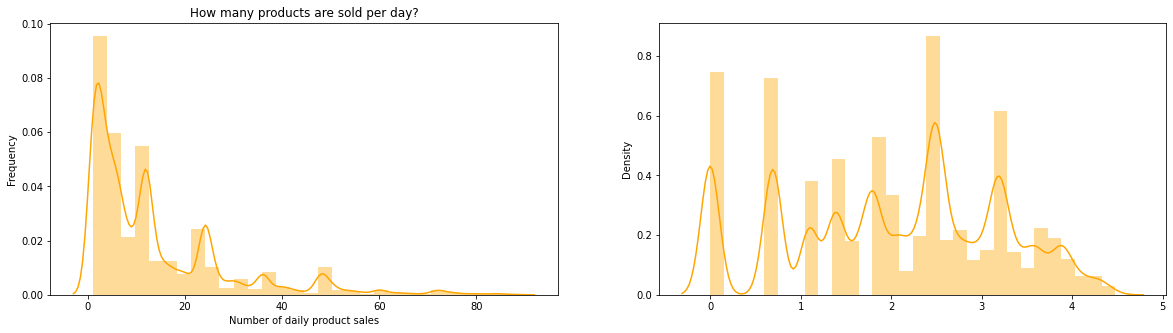

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(daily_data.Quantity.values, kde=True, ax=ax[0], color="Orange", bins=30);
sns.distplot(np.log(daily_data.Quantity.values), kde=True, ax=ax[1], color="Orange", bins=30);
ax[0].set_xlabel("Number of daily product sales");
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many products are sold per day?");

In [ ]:
#How to predict daily product sales? 

In [ ]:
class CatHyperparameter:
    
    def __init__(self,
                 loss="RMSE",
                 metric="RMSE",
                 iterations=1000,
                 max_depth=4,
                 l2_leaf_reg=3,
                 #learning_rate=0.5,
                 seed=0):
        self.loss = loss,
        self.metric = metric,
        self.max_depth = max_depth,
        self.l2_leaf_reg = l2_leaf_reg,
        #self.learning_rate = learning_rate,
        self.iterations=iterations
        self.seed = seed

In [ ]:
class Catmodel:
    
    def __init__(self, name, params):
        self.name = name
        self.params = params
    
    def set_data_pool(self, train_pool, val_pool):
        self.train_pool = train_pool
        self.val_pool = val_pool
    
    def set_data(self, x, y, week):
        cat_features_idx = np.where(x.dtypes != np.float)[0]
        x_train, self.x_val = x.loc[x.Week < week], x.loc[x.Week >= week]
        y_train, self.y_val = y.loc[x.Week < week], y.loc[x.Week >= week]
        self.train_pool = pool(x_train, y_train, cat_features=cat_features_idx)
        self.val_pool = pool(self.x_val, self.y_val, cat_features=cat_features_idx)
    
    def prepare_model(self):
        self.model = CatBoostRegressor(
                loss_function = self.params.loss[0],
                random_seed = self.params.seed,
                logging_level = 'Silent',
                iterations = self.params.iterations,
                max_depth = self.params.max_depth[0],
                #learning_rate = self.params.learning_rate[0],
                l2_leaf_reg = self.params.l2_leaf_reg[0],
                od_type='Iter',
                od_wait=40,
                train_dir=self.name,
                has_time=True
            )
    
    def learn(self, plot=False):
        self.prepare_model()
        self.model.fit(self.train_pool, eval_set=self.val_pool, plot=plot);
        print("{}, early-stopped model tree count {}".format(
            self.name, self.model.tree_count_
        ))
    
    def score(self):
        return self.model.score(self.val_pool)
    
    def show_importances(self, kind="bar"):
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.val_pool)
        if kind=="bar":
            return shap.summary_plot(shap_values, self.x_val, plot_type="bar")
        return shap.summary_plot(shap_values, self.x_val)
    
    def get_val_results(self):
        self.results = pd.DataFrame(self.y_val)
        self.results["prediction"] = self.predict(self.x_val)
        self.results["error"] = np.abs(
            self.results[self.results.columns.values[0]].values - self.results.prediction)
        self.results["Month"] = self.x_val.Month
        self.results["SquaredError"] = self.results.error.apply(lambda l: np.power(l, 2))
    
    def show_val_results(self):
        self.get_val_results()
        fig, ax = plt.subplots(1,2,figsize=(20,5))
        sns.distplot(self.results.error, ax=ax[0])
        ax[0].set_xlabel("Single absolute error")
        ax[0].set_ylabel("Density")
        self.median_absolute_error = np.median(self.results.error)
        print("Median absolute error: {}".format(self.median_absolute_error))
        ax[0].axvline(self.median_absolute_error, c="black")
        ax[1].scatter(self.results.prediction.values,
                      self.results[self.results.columns[0]].values,
                      c=self.results.error, cmap="RdYlBu_r", s=1)
        ax[1].set_xlabel("Prediction")
        ax[1].set_ylabel("Target")
        return ax
    
    def get_monthly_RMSE(self):
        return self.results.groupby("Month").SquaredError.mean().apply(lambda l: np.sqrt(l))
        
    def predict(self, x):
        return self.model.predict(x)
    
    def get_dependence_plot(self, feature1, feature2=None):
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.val_pool)
        if feature2 is None:
            return shap.dependence_plot(
                feature1,
                shap_values,
                self.x_val,
            )
        else:
            return shap.dependence_plot(
                feature1,
                shap_values,
                self.x_val,
                interaction_index=feature2
            )

In [ ]:
!pip install -q matplotlib-venn

In [ ]:
!apt-get -qq install -y libfluidsynth1

Selecting previously unselected package libfluidsynth1:amd64.
(Reading database ... 145480 files and directories currently installed.)
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.6/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link



In [ ]:
pip install GPyOpt

     |████████████████████████████████| 61kB 3.6MB/s 
     |████████████████████████████████| 1.0MB 8.4MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-cp36-none-any.whl size=83623 sha256=beabea520ef8cb345311b123d95502c9af6bb6e78a311186756f20ca492e6d9c
  Stored in directory: /root/.cache/pip/wheels/b2/00/69/cfa967a125cf25e66f644be6193ad6f0edf231147879ad714f
  Created wheel for GPy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2633902 sha256=db7e87289a0ca3eeb0b8ac51668dcc15a1c510f1c10bf7fbc5f66e27b32f31ea
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102552 sha256=46aa426a46d3f04ecb019acf296102ffcf5af2418972af787fa29af4f0d2df22
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPyOpt GPy paramz


In [ ]:
import GPyOpt

class Hypertuner:
    
    def __init__(self, model, max_iter=10, max_time=10,max_depth=6, max_l2_leaf_reg=20):
        self.bounds = [{'name': 'depth','type': 'discrete','domain': (1,max_depth)},
                       {'name': 'l2_leaf_reg','type': 'discrete','domain': (1,max_l2_leaf_reg)}]
        self.model = model
        self.max_iter=max_iter
        self.max_time=max_time
        self.best_depth = None
        self.best_l2_leaf_reg = None
    
    def objective(self, params):
        params = params[0]
        params = CatHyperparameter(
            max_depth=params[0],
            l2_leaf_reg=params[1]
        )
        self.model.params = params
        self.model.learn()
        return self.model.score()
    
    def learn(self):
        np.random.seed(777)
        optimizer = GPyOpt.methods.BayesianOptimization(
            f=self.objective, domain=self.bounds,
            acquisition_type ='EI',
            acquisition_par = 0.2,
            exact_eval=True)
        optimizer.run_optimization(self.max_iter, self.max_time)
        optimizer.plot_convergence()
        best = optimizer.x[np.argmin(optimizer.y)]
        self.best_depth = best[0]
        self.best_l2_leaf_reg = best[1]
        print("Optimal depth is {} and optimal l2-leaf-reg is {}".format(self.best_depth, self.best_l2_leaf_reg))
        print('Optimal RMSE:', np.min(optimizer.Y))
    
    def retrain_catmodel(self):
        params = CatHyperparameter(
            max_depth=self.best_depth,
            l2_leaf_reg=self.best_l2_leaf_reg
        )
        self.model.params = params
        self.model.learn(plot=True)
        return self.model

In [ ]:
#Time series validation Catfamily

In [ ]:
from multiprocessing import pool
class CatFamily:
    
    def __init__(self, params, x, y, n_splits=2):
        self.family = {}
        self.cat_features_idx = np.where(x.dtypes != np.float)[0]
        self.x = x.values
        self.y = y.values
        self.n_splits = n_splits
        self.params = params
    
    def set_validation_strategy(self):
        self.cv = TimeSeriesSplit(max_train_size = None,
                                  n_splits = self.n_splits)
        self.gen = self.cv.split(self.x)
    
    def get_split(self):
        train_idx, val_idx = next(self.gen)
        x_train, x_val = self.x[train_idx], self.x[val_idx]
        y_train, y_val = self.y[train_idx], self.y[val_idx]
        train_pool = pool(x_train, y_train, cat_features=self.cat_features_idx)
        val_pool = pool(x_val, y_val, cat_features=self.cat_features_idx)
        return train_pool, val_pool
    
    def learn(self):
        self.set_validation_strategy()
        self.model_names = []
        self.model_scores = []
        for split in range(self.n_splits):
            name = 'Model_cv_' + str(split) + '/'
            train_pool, val_pool = self.get_split()
            self.model_names.append(name)
            self.family[name], score = self.fit_catmodel(name, train_pool, val_pool)
            self.model_scores.append(score)
    
    def fit_catmodel(self, name, train_pool, val_pool):
        cat = Catmodel(name, train_pool, val_pool, self.params)
        cat.prepare_model()
        cat.learn()
        score = cat.score()
        return cat, score
    
    def score(self):
        return np.mean(self.model_scores)
    
    def show_learning(self):
        widget = MetricVisualizer(self.model_names)
        widget.start()

    def show_importances(self):
        name = self.model_names[-1]
        cat = self.family[name]
        explainer = shap.TreeExplainer(cat.model)
        shap_values = explainer.shap_values(cat.val_pool)
        return shap.summary_plot(shap_values, x, plot_type="bar")

In [ ]:
#Baseline model & result analysis 

In [ ]:
daily_data.head(2)

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,Revenue
0,2010-12-01,2010,4,12,48,2,335,1,10002,60,51.0
1,2010-12-01,2010,4,12,48,2,335,1,10125,2,1.7


In [ ]:
week = daily_data.Week.max() - 2
print("Validation after week {}".format(week))
print("Validation starts at timepoint {}".format(
    daily_data[daily_data.Week==week].Date.min()
))

Validation after week 49
Validation starts at timepoint 2010-12-06 00:00:00


In [ ]:
!pip install catboost

     |████████████████████████████████| 65.8MB 55kB/s 


In [ ]:
x = daily_data.drop(["Quantity", "Revenue", "Date"], axis=1)


In [ ]:
daily_data.Quantity = np.log(daily_data.Quantity)
y = daily_data.Quantity
params = CatHyperparameter()


In [ ]:

model = Catmodel("baseline", params)
model.set_data(x, y, week)
model.learn(plot=True)

NameError: ignored

In [ ]:
model.score()

NameError: ignored

In [ ]:
model.show_val_results();

In [ ]:
model.show_importances()

In [ ]:
model.show_importances(kind=None)

In [ ]:
np.mean(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))

In [ ]:
np.median(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))

In [ ]:
Bayesian Hyperparameter Search with GPyOpt 

In [ ]:
#search = Hypertuner(model, max_depth=5, max_l2_leaf_reg=30)
#search.learn()
#model = search.retrain_catmodel()
#print(model.score())
#model.show_importances(kind=None)

In [ ]:

Feature engineering
Creating product types

In [ ]:
products = pd.DataFrame(index=data.loc[data.Week < week].StockCode.unique(), columns = ["MedianPrice"])

products["MedianPrice"] = data.loc[data.Week < week].groupby("StockCode").UnitPrice.median()
products["MedianQuantities"] = data.loc[data.Week < week].groupby("StockCode").Quantity.median()
products["Customers"] = data.loc[data.Week < week].groupby("StockCode").CustomerID.nunique()
products["DescriptionLength"] = data.loc[data.Week < week].groupby("StockCode").DescriptionLength.median()
#products["StockCode"] = products.index.values
org_cols = np.copy(products.columns.values)
products.head()

In [ ]:
for col in org_cols:
    if col != "StockCode":
        products[col] = boxcox(products[col])[0]

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].scatter(products.MedianPrice.values, products.MedianQuantities.values,
           c=products.Customers.values, cmap="coolwarm_r")
ax[0].set_xlabel("Boxcox-Median-UnitPrice")
ax[0].set_ylabel("Boxcox-Median-Quantities")

In [ ]:
X = products.values
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
km = KMeans(n_clusters=30)
products["cluster"] = km.fit_predict(X)

daily_data["ProductType"] = daily_data.StockCode.map(products.cluster)
daily_data.ProductType = daily_data.ProductType.astype("object")
daily_data.head()

In [ ]:
Baseline for product types

In [ ]:
daily_data["KnownStockCodeUnitPriceMedian"] = daily_data.StockCode.map(
    data.groupby("StockCode").UnitPrice.median())

known_price_iqr = data.groupby("StockCode").UnitPrice.quantile(0.75) 
known_price_iqr -= data.groupby("StockCode").UnitPrice.quantile(0.25) 
daily_data["KnownStockCodeUnitPriceIQR"] = daily_data.StockCode.map(known_price_iqr)

In [ ]:
to_group = ["StockCode", "Year", "Month", "Week", "Weekday"]

daily_data = daily_data.set_index(to_group)
daily_data["KnownStockCodePrice_WW_median"] = daily_data.index.map(
    data.groupby(to_group).UnitPrice.median())
daily_data["KnownStockCodePrice_WW_mean"] = daily_data.index.map(
    data.groupby(to_group).UnitPrice.mean().apply(lambda l: np.round(l, 2)))
daily_data["KnownStockCodePrice_WW_std"] = daily_data.index.map(
    data.groupby(to_group).UnitPrice.std().apply(lambda l: np.round(l, 2)))

daily_data = daily_data.reset_index()

In [ ]:
daily_data.head()

In [ ]:
Temporal patterns

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(daily_data.groupby("Date").Quantity.sum(), marker='+', c="darkorange")
plt.plot(daily_data.groupby("Date").Quantity.sum().rolling(window=30, center=True).mean(),
        c="red")
plt.xticks(rotation=90);
plt.title("How many quantities are sold per day over the given time?");

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
yearmonth = ["Dec-2010", "Jan-2011", "Feb-2011", "Mar-2011", "Apr-2011", "May-2011",
             "Jun-2011", "Jul-1011", "Aug-2011", "Sep-2011", "Oct-2011", "Nov-2011", 
             "Dec-2011"]

daily_data.groupby("Weekday").Quantity.sum().plot(
    ax=ax[0], marker='o', label="Quantity", c="darkorange");
ax[0].legend();
ax[0].set_xticks(np.arange(0,7))
ax[0].set_xticklabels(weekdays);
ax[0].set_xlabel("")
ax[0].set_title("Total sales per weekday");

ax[1].plot(daily_data.groupby(["Year", "Month"]).Quantity.sum().values,
    marker='o', label="Quantities", c="darkorange");
ax[1].set_xticklabels(yearmonth, rotation=90)
ax[1].set_xticks(np.arange(0, len(yearmonth)))
ax[1].legend();
ax[1].set_title("Total sales per month");

In [ ]:
daily_data["PreChristmas"] = (daily_data.Dayofyear <= 358) & (daily_data.Dayofyear >= 243) 

In [ ]:
for col in ["Weekday", "Month", "Quarter"]:
    daily_data = daily_data.set_index(col)
    daily_data[col+"Quantity_mean"] = daily_data.loc[daily_data.Week < week].groupby(col).Quantity.mean()
    daily_data[col+"Quantity_median"] = daily_data.loc[daily_data.Week < week].groupby(col).Quantity.median()
    daily_data[col+"Quantity_mean_median_diff"] = daily_data[col+"Quantity_mean"] - daily_data[col+"Quantity_median"]
    daily_data[col+"Quantity_IQR"] = daily_data.loc[
        daily_data.Week < week].groupby(col).Quantity.quantile(0.75) - daily_data.loc[
        daily_data.Week < week].groupby(col).Quantity.quantile(0.25)
    daily_data = daily_data.reset_index()
daily_data.head()

In [ ]:
to_group = ["StockCode", "PreChristmas"]
daily_data = daily_data.set_index(to_group)
daily_data["PreChristmasMeanQuantity"] = daily_data.loc[
    daily_data.Week < week].groupby(to_group).Quantity.mean().apply(lambda l: np.round(l, 1))
daily_data["PreChristmasMedianQuantity"] = daily_data.loc[
    daily_data.Week < week].groupby(to_group).Quantity.median().apply(lambda l: np.round(l, 1))
daily_data["PreChristmasStdQuantity"] = daily_data.loc[
    daily_data.Week < week].groupby(to_group).Quantity.std().apply(lambda l: np.round(l, 1))
daily_data = daily_data.reset_index()

In [ ]:
for delta in range(1,4):
    to_group = ["Week","Weekday","ProductType"]
    daily_data = daily_data.set_index(to_group)
        
    daily_data["QuantityProducttypeWeekWeekdayLag_" + str(delta) + "_median"] = daily_data.groupby(
        to_group).Quantity.median().apply(lambda l: np.round(l,1)).shift(delta)
    
    daily_data = daily_data.reset_index()
    daily_data.loc[daily_data.Week >= (week+delta),
                   "QuantityProductTypeWeekWeekdayLag_" + str(delta) + "_median"] = np.nan

In [ ]:
data["ProductType"] = data.StockCode.map(products.cluster)

In [ ]:
daily_data["TransactionsPerProductType"] = daily_data.ProductType.map(data.loc[data.Week < week].groupby("ProductType").InvoiceNo.nunique())